# Procesamiento de imágenes 2022-2


# Implementación

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

# import OS module
import os
import math

import numpy as np
import cv2
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, ConcatDataset
from torch.autograd import Variable

import torch
import torch.nn.functional as F
import torch.optim as optim

from torch import nn
from torch import Tensor
from torchsummary import summary


## 1. Obtención de datos
--- 


In [3]:
path = '/content/drive/MyDrive/Proyecto imagenes 2022-2/dataset/propio'

dir_list = os.listdir(path)


Se define las letras del abecedario que vamos a clasificar y al mismo tiempo le asignamos un valor entero. Por ejemplo A : 0, B: 1.

In [4]:
DECODE_LABELS_LIST = [ chr(x) for x in range(65 , 65 + 26) if chr(x) not in ['J', 'Z']]
DECODE_LABELS = { label: i for i, label in enumerate(DECODE_LABELS_LIST)}
print(DECODE_LABELS)

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'O': 13, 'P': 14, 'Q': 15, 'R': 16, 'S': 17, 'T': 18, 'U': 19, 'V': 20, 'W': 21, 'X': 22, 'Y': 23}


Leemos todos las imagenes con el formato JPG de la carpeta donde guardamos las imágenes. Y la primera letra de la imagen es la letra que representa.

In [5]:
def load_data():
  imgs = []
  labels = np.array([], dtype=np.int16)

  for filename in dir_list:
      frame = cv2.imread(path + '/' + filename)
      imgs.append(frame)
      labels = np.append(labels, DECODE_LABELS[filename[0]])
  return imgs, labels

In [6]:
all_imgs, labels = load_data()

In [7]:
len(all_imgs) , labels.shape

(192, (192,))

## 2. Pre procesamiento
--- 

En esta etapa identificamos la mano en la imágen y luego hacemos un recorte en dicha área. 
Finalmente cambiamos el tamaña del recorte a 32x32 pixeles por canal.

Analizamos distintos espacios de color

In [8]:
def plot_RGB_HSV(img):
  img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
  B, G, R = img[:,:,0], img[:,:,1], img[:,:,2]
  H, S, V = img_hsv[:,:,0], img_hsv[:,:,1], img_hsv[:,:,2]



  plot_data = [ R, G , B, H, S, V]
  titles = [ "R", "G", "B", "H", "S", "V", ]

  plt.figure(figsize=(10,10))
  for idx, data in enumerate(plot_data):

    plt.subplot(2,3,idx+1)
    plt.imshow(data , cmap='gray')
    plt.title(titles[idx], fontsize=16)



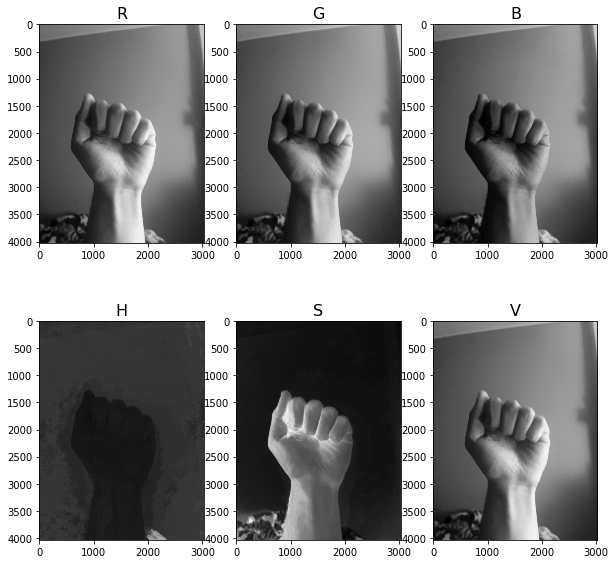

In [9]:
plot_RGB_HSV(all_imgs[0])

Se decide utilizar un Kernel

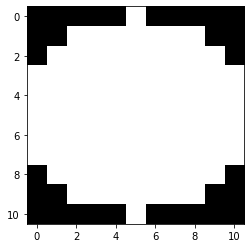

In [37]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
plt.imshow(kernel , cmap='gray')

In [10]:
def resize_img(img, new_width=None, new_height=None):
  
  height, width = img.shape[0], img.shape[1]  
  
  if new_width:
    new_size = (new_width, int(height*new_width/width))
  elif new_height:
    new_size = (int(width*new_height/height), new_height)
  else:
    return img.copy()

  resized_img = cv2.resize(img.copy(), dsize=new_size, interpolation=cv2.INTER_AREA)
  return resized_img

def threshold_hand_color(img, plot=False):

  lower = np.array([0, 48, 40], dtype = "uint8")
  upper = np.array([20, 255, 255], dtype = "uint8")

  frame = resize_img(img.copy(), new_height=400)
  converted = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
  skinMask = cv2.inRange(converted, lower, upper)

  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
  skinMask_e = cv2.erode(skinMask, kernel, iterations = 2)
  skinMask_d = cv2.dilate(skinMask_e, kernel, iterations = 2)

  skinMask_g = cv2.GaussianBlur(skinMask_d, (3, 3), 0)

  if plot:
    img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plot_data = [ img_rgb, skinMask, skinMask_e , skinMask_d]
    titles = [ "Imagen original", "Filtro de color", "Erosion", "Dilatación"]

    plt.figure(figsize=(20,10))
    for idx, data in enumerate(plot_data):

      plt.subplot(1,4,idx+1)
      plt.imshow(data , cmap='gray')
      plt.title(titles[idx])

  return skinMask


def find_largest_contour(mask):

  contours, hierarchy= cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  sorted_contours= sorted(contours, key=cv2.contourArea, reverse= True)
  largest_contours= sorted_contours[0]

  return largest_contours

def crop_img(original_img, largest_contour):
  """ Recortamos la imágen de acuerdo al contorno más grande"""

  height, width = original_img.shape[0], original_img.shape[1]

  lh, lw = largest_contour.transpose()
  
  x2, x1 = lh.max(), lh.min()
  y2, y1 = lw.max(), lw.min()

  x_size = x2 - x1
  y_size = y2 - y1

  biggest_side = x_size if x_size > y_size else y_size
  r = int(biggest_side*1.15/2)

  x_center = int((x1 + x2)/2)
  y_center = int((y1 + y2)/2)

  #Verificamos que el recorte no exceda los límites de la imagen
  if y_center-r < 0:
    y_center = r
  elif y_center > height:
    y_center = height - r
  
  if x_center-r < 0:
    x_center = r
  elif x_center > width:
    x_center = width - r


  img_cropped = original_img.copy()[y_center-r:y_center+r, x_center-r:x_center+r]

  img_cropped = cv2.resize(img_cropped, dsize=(32,32), interpolation=cv2.INTER_AREA)

  return img_cropped

def preprocess(img):
  """ Juntamos todo el procesamiento en una función  """

  frame_resized = resize_img(img, new_height=400)
  mask = threshold_hand_color(img)
  largest_contour = find_largest_contour(mask)

  resized_RGB = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2RGB)
  img_cropped = crop_img(frame_resized.copy(), largest_contour)
  img_cropped = cv2.cvtColor(img_cropped, cv2.COLOR_BGR2RGB)
  return img_cropped, resized_RGB

Obtenemos los datos preprocesados.

In [67]:

preprocessed_data = []

for idx, label in enumerate(labels):
    img_cropped, _ = preprocess(all_imgs[idx])
    preprocessed_data.append(img_cropped)

print(f"Tenemos {len(preprocessed_data)} imagenes preprocesadas")

Tenemos 192 imagenes preprocesadas


In [ ]:
threshold_hand_color(all_imgs[55], plot=True)

## 3. Aumentamos las imagenes
--- 


In [68]:

def augmentate(img):

  ref_img = img.copy()
  reverse_up = ref_img[::-1]
  rotate_left = ref_img.transpose((1,0,2)) 
  rotate_right = reverse_up.transpose((1,0,2)) 

  return reverse_up, rotate_right, rotate_left


In [69]:

augmented_data = []
new_labels = np.array([], dtype=np.int16)

for idx, label in enumerate(labels):
    temp = preprocessed_data[idx]
    
    new_labels = np.append(new_labels, label)
    augmented = augmentate(temp)
    augmented_data.append(temp)

    for img in augmented:
      augmented_data.append(img)
      new_labels = np.append(new_labels, label)

print(f"Tenemos {len(augmented_data)} imagenes para dividir entre entrenamiento, validación y evaluación.")

Tenemos 768 imagenes para dividir entre entrenamiento, validación y evaluación.


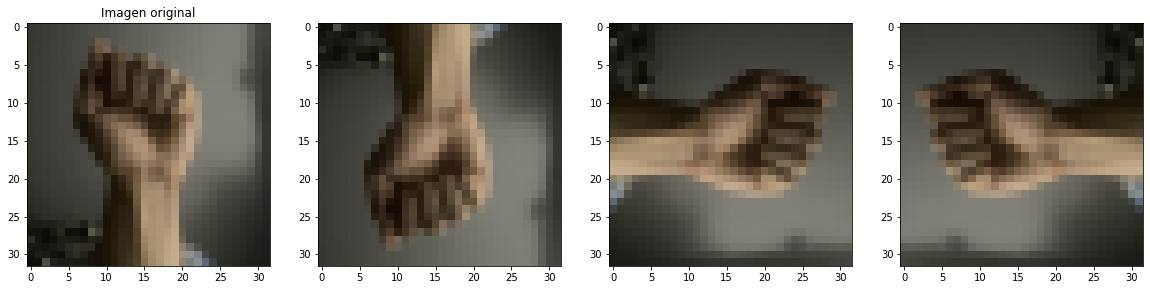

In [14]:

def plot_aumented(img):

  reverse_up, rotate_right, rotate_left = augmentate(img)

  aumented_data = [ img, reverse_up , rotate_right, rotate_left]

  plt.figure(figsize=(20,10))
  for idx, data in enumerate(aumented_data):

    plt.subplot(1,4,idx+1)
    plt.imshow(data , cmap='gray')
    if idx == 0:
      plt.title("Imagen original")


plot_aumented(preprocessed_data[0])

In [ ]:
plt.figure(figsize=(20,30))

for idx, label in enumerate(labels):
    plt.subplot(int(len(labels)/5),10,idx+1)
    test_img = preprocessed_data[idx]
    plt.imshow(test_img , cmap='gray')
    plt.title(f'Hand Cropped: {DECODE_LABELS_LIST[label]} ')

## 4. Clasificación
--- 
En esta etapa definimos la red neuronal por utilizar y realizamos el entrenamiento y evaluación de la red neuronal.

### Normalizamos los datos y almacenamos en un Loader
--- 

In [ ]:
def get_deafault_device():
  return torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def to_device(entity, device):
  if isinstance(entity, (list, tuple)):
    return [to_device(elem, device) for elem in entity]
  return entity.to(device, non_blocking = True)


class DeviceDataLoader(): #hilft uns beim tranferieren des Daten es an die richtigen Devices zu schicken

  def __init__(self, dataloader, device):
    self.dl = dataloader
    self.device = device

  def __iter__(self):
    for a in self.dl:
      yield to_device(a, self.device)

  def __len__(self):
    return len(self.dl)

In [111]:

dataset = np.array(augmented_data)
dataset = dataset / 255
dataset = dataset.transpose((0,3,1,2))
torch_labels = torch.from_numpy(new_labels)
torch_dataset = torch.from_numpy(dataset)

if torch.cuda.is_available():
  torch_dataset, torch_labels = torch_dataset.cuda(), torch_labels.cuda()

print(f"Los datos tienen el siguiente tamaño. {dataset.shape}")

dataset = torch.utils.data.TensorDataset(torch_dataset, torch_labels)


Los datos tienen el siguiente tamaño. (768, 3, 32, 32)


In [112]:
batch_size = 64

train_size = int(len(dataset)*0.6)

val_size = int((len(dataset) - train_size)/2)
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)


In [113]:

device = get_deafault_device()
train_dataset = DeviceDataLoader(train_dataset, device)
test_loader = DeviceDataLoader(test_loader, device)
val_dataset = DeviceDataLoader(val_dataset, device)

# set cpu or gpu enabled device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type

# log type of device enabled
print('[LOG] notebook with {} computation enabled'.format(str(device)))

[LOG] notebook with cuda computation enabled


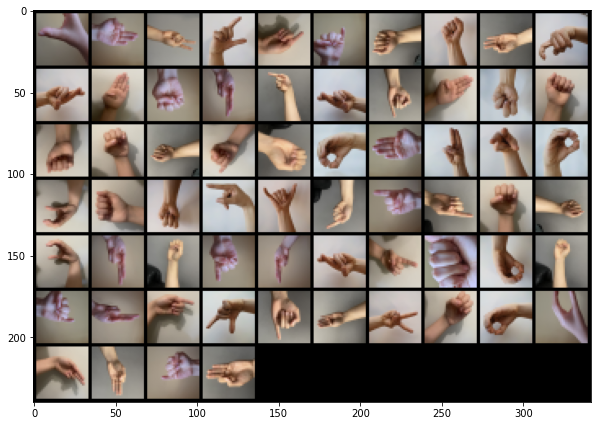

In [172]:
from torchvision.utils import make_grid

def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.imshow(make_grid(images.cpu(), 10).permute(1,2,0)) #permute the images to make sure height and width are in the correct spot
    break

show_batch(train_loader)

### Diseño de red neuronal convolucional 
--- 

In [115]:

def conv_block(in_channels, out_channels, pool = False):
  layers = [nn.Conv2d(in_channels, out_channels, kernel_size= 3, padding = 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace = True)
            ]
  if pool:
    layers.append(nn.MaxPool2d(2))
  return nn.Sequential(*layers)


class ResnetX(nn.Module):

  def __init__(self, in_channels, num_classes):


    super().__init__()
    self.conv1 = conv_block(in_channels, 64)
    self.conv2 = conv_block(64, 128, pool = True)
    self.res1 = nn.Sequential(conv_block(128,128),conv_block(128,128))

    self.conv3 = conv_block(128, 256, pool = True)
    self.conv4 = conv_block(256, 512, pool = True)
    self.res2 = nn.Sequential(conv_block(512,512),conv_block(512,512))

    self.classifier = nn.Sequential(
        nn.MaxPool2d(4),
        nn.Flatten(),
        nn.Dropout(0.2),
        nn.Linear(512, num_classes)

    )

  def forward(self, x):
    out = self.conv1(x)
    out = self.conv2(out)
    out = self.res1(out) + out # this is what was mentioned before with the ResidualBlocks
    out = self.conv3(out)
    out = self.conv4(out)
    out = self.res2(out) + out # here again
    return self.classifier(out)


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(44944, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 24)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        #out = F.softmax(x, dim=-1)
        return x


In [ ]:
ResnetX(3,24)


In [50]:
total = 0
for parameter in ResnetX(3,24).parameters():
    total = total + len(parameter)
print(f"En total hay {total} parametros")

En total hay 9008 parametros


### Entrenamiento
--- 

In [153]:
from torch.optim import optimizer
from torch import optim
from torch.nn.modules import loss


def accuracy(logits, labels):
  pred, predClassId = torch.max(logits, dim = 1)

  return torch.tensor(torch.sum(predClassId == labels).item() / len(logits))


def evaluate(model, dl, loss_function):
  model.eval()
  batch_losses , batch_accs = [], []
  for images, labels in dl:
    with torch.no_grad():

      logits = model(images.float())

    batch_losses.append(loss_function(logits, labels))
    batch_accs.append(accuracy(logits, labels))
  epoch_avg_loss = torch.stack(batch_losses).mean().item()
  epoch_avg_acc = torch.stack(batch_accs).mean()
  
  return epoch_avg_loss, epoch_avg_acc




def train(model, train_dataset, val_dataset, epochs, max_lr, loss_function, optim):
  optimizer = optim(model.parameters(), max_lr)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs * len(train_dataset))


  results = {
      "avg_loss": [], 
      "avg_acc": [], 
      "lr": []
  }


  for epoch in range(epochs):
    model.train()
    lrs = []

    # init collection of mini-batch losses

    counter = 0
    for images, labels in train_dataset:
      counter += 1
      percentage = round(counter/len(train_dataset)*100,1)
      #print(f"{percentage}% done in epoch nr {epoch}")
      logits = model(images.float())
      #print(labels)
      loss = loss_function(logits, labels)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      lrs.append(optimizer.param_groups[0]["lr"])
      scheduler.step()
      # collect mini-batch reconstruction loss
    
    epoch_avg_loss, epoch_avg_acc = evaluate(model, val_dataset, loss_function)
    print(f"Epoch {epoch}: 'epoch_avg_acc': {epoch_avg_acc} 'epoch_avg_loss': {epoch_avg_loss} ")

    results["avg_loss"].append(epoch_avg_loss)
    results["avg_acc"].append(epoch_avg_acc)
    results["lr"].append(lrs)
    
    
  return results, lrs



In [154]:
%%time

# Set how many epochs
epochs = 40
model = ResnetX(3,24) # Input 3 channels and output 24 classes
model = to_device(model, device)

# Set maximun learning rate
max_lr = 1e-2
loss_function = nn.functional.cross_entropy
optim = torch.optim.Adam


results = train(model.float(), train_loader, val_loader, epochs, max_lr, loss_function, optim)

Epoch 0: 'epoch_avg_acc': 0.0520833320915699 'epoch_avg_loss': 2.9883313179016113 
Epoch 1: 'epoch_avg_acc': 0.09334935992956161 'epoch_avg_loss': 3.604128360748291 
Epoch 2: 'epoch_avg_acc': 0.11899038404226303 'epoch_avg_loss': 4.607485771179199 
Epoch 3: 'epoch_avg_acc': 0.15504807233810425 'epoch_avg_loss': 5.190532684326172 
Epoch 4: 'epoch_avg_acc': 0.13461537659168243 'epoch_avg_loss': 9.518308639526367 
Epoch 5: 'epoch_avg_acc': 0.09054487198591232 'epoch_avg_loss': 9.10068416595459 
Epoch 6: 'epoch_avg_acc': 0.21754807233810425 'epoch_avg_loss': 7.180548667907715 
Epoch 7: 'epoch_avg_acc': 0.11097756773233414 'epoch_avg_loss': 21.891233444213867 
Epoch 8: 'epoch_avg_acc': 0.051682692021131516 'epoch_avg_loss': 44.377532958984375 
Epoch 9: 'epoch_avg_acc': 0.09815704822540283 'epoch_avg_loss': 19.79791259765625 
Epoch 10: 'epoch_avg_acc': 0.03365384414792061 'epoch_avg_loss': 18.17691421508789 
Epoch 11: 'epoch_avg_acc': 0.16065704822540283 'epoch_avg_loss': 10.370325088500977 

Vemos los resultados del entrenamiento.

In [155]:
def plot(dataset, title, xlabel, ylabel):
  # prepare plot
  fig = plt.figure()
  ax = fig.add_subplot(111)

  # add grid
  ax.grid(linestyle='dotted')

  # plot the training epochs vs. the epochs' classification error
  ax.plot(np.array(range(1, len(dataset)+1)), dataset, label='epoch loss (blue)')

  # add axis legends
  ax.set_xlabel(xlabel, fontsize=10)
  ax.set_ylabel(ylabel, fontsize=10)

  # set plot legend
  plt.legend(loc="upper center", numpoints=1, fancybox=True)

  # add plot title
  plt.title(title, fontsize=10);

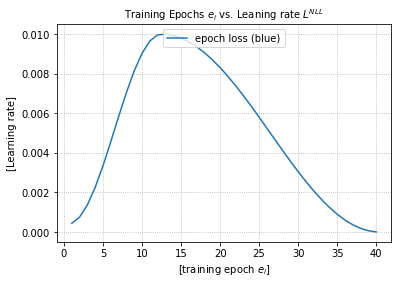

In [156]:
lrs = [np.mean(x) for x in (results[0]['lr'])]
plot(lrs, 'Training Epochs $e_i$ vs. Leaning rate $L^{NLL}$', "[training epoch $e_i$]", "[Learning rate]" )

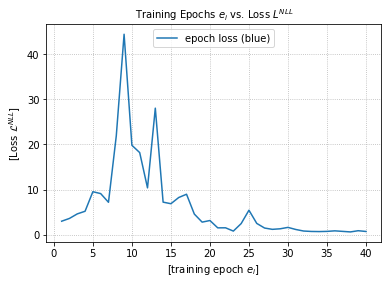

In [157]:
avg_losses = results[0]['avg_loss']
plot(avg_losses, 'Training Epochs $e_i$ vs. Loss $L^{NLL}$', "[training epoch $e_i$]", "[Loss $\mathcal{L}^{NLL}$]" )

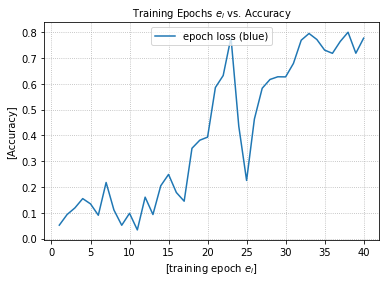

In [158]:
avg_acc = results[0]['avg_acc']
plot(avg_acc,'Training Epochs $e_i$ vs. Accuracy', "[training epoch $e_i$]", "[Accuracy]")

### Evaluación del modelo
--

In [159]:
Avg_loss, Avg_accuracy = evaluate(model, test_loader, loss_function)
print(f"'Accuracy': {round(float(Avg_accuracy * 100), 2) }% 'Loss': {round(Avg_loss, 5) } ")

'Accuracy': 82.61% 'Loss': 0.51634 


In [58]:
path = '/content/drive/MyDrive/Proyecto imagenes 2022-2/'
torch.save(model.state_dict(), f"{path}Clasificador.pth")

# Tests
---

In [167]:

def test_image(image_path,model):
  
  img = cv2.imread(image_path)

  img_cropped, _ = preprocess(img)
  data = img_cropped / 255
  data = data.transpose(2,0,1)
  torch_img = torch.from_numpy(data).float()
  img_normalized = torch_img.unsqueeze_(0).cpu()

  with torch.no_grad():
      model.eval()  
      output = model(img_normalized)
      #print(output)
      index = output.data.numpy().argmax()
      class_name = DECODE_LABELS_LIST[index]
      
      return class_name, img_cropped


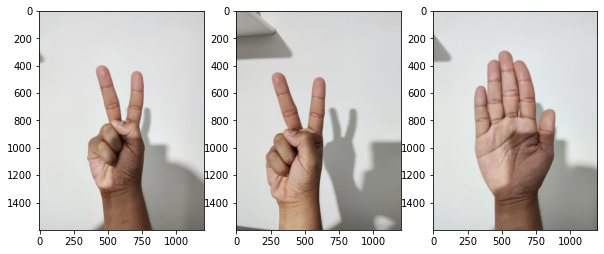

In [161]:

plt.figure(figsize=(10,10))
for i in range(3):
  img = cv2.imread(f"/content/test{i+1}.jpeg")
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  plt.subplot(1, 3, i+1)
  plt.imshow(img_rgb)

Demoro 0.060 segundos
Demoro 0.047 segundos
Demoro 0.047 segundos


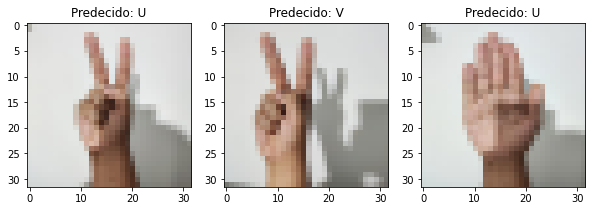

In [171]:
import time

plt.figure(figsize=(10,10))
for i in range(3):
  start = time.time()
  class_name, img_cropped = test_image(f"/content/test{i+1}.jpeg",model.cpu())
  end = time.time()
  
  print("Demoro {:.3f} segundos".format(end - start))
  
  plt.subplot(1, 3, i+1)
  plt.imshow(img_cropped)
  plt.title(f"Predecido: {class_name}")